In [1]:
import sys
sys.path.append(r'path to github repo folder')

In [1]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos/')

In [9]:
from rolling_percentile import rolling_percentile, initialize_rp

In [10]:
from rolling_percentile import rolling_percentile, initialize_rpimport numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

# Core usage and comparison to pandas

In [11]:
x_in = np.random.rand(1000,10000)

window_length = 1001 # must be odd integer
percentile = 10 # 0-100

In [12]:
initialize_rp() # not necessary, just used to compile all the jit functions and store in cache
tic = time()
# This is the core function. Note that the rolling percentile is calculated along dim 1 (rows), and that edges are currently set to NaNs.
x_out_rp = rolling_percentile(x_in, win_len=window_length, ptile=percentile)
print(f'rolling_percentile computation time: {time() - tic} seconds')

rolling_percentile computation time: 0.7890269756317139 seconds


In [13]:
x_in_df = pd.DataFrame(x_in)
tic = time()
# This is pandas' version. Note that these settings are intended to match how 'rolling_percentile' works.
x_out_pd = x_in_df.rolling(window=window_length, center=True, axis=1).quantile(quantile=(percentile/100))
print(f'pandas computation time: {time() - tic} seconds')
x_out_pd = np.array(x_out_pd)

pandas computation time: 4.34856390953064 seconds


In [14]:
win_half_len = window_length//2
outputs_equivalent_check = np.allclose(x_out_rp[:,win_half_len:-(win_half_len+1)], x_out_pd[:,win_half_len:-(win_half_len+1)])
print(f'Outputs from rolling_percentile and pandas are exactly the same: {outputs_equivalent_check}')

Outputs from rolling_percentile and pandas are exactly the same: True


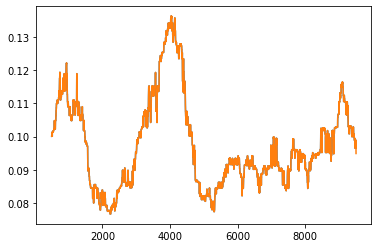

In [15]:
plt.figure()
plt.plot(x_out_rp[0])
plt.plot(x_out_pd[0])

# Benchmarking

In [88]:
from blist import sortedlist as blist_sortedlist
from sortedcontainers import SortedList as sortcont_SortedList

from bisect import bisect_left, insort
from blist import blist

import rolling_quantiles as rq

In [172]:
x_in = np.random.rand(36, 2_000_000)

ptile = 10

wins_toTest = 2**np.arange(1,19)+1
print(f'window lengths to test: {wins_toTest}')

window lengths to test: [     3      5      9     17     33     65    129    257    513   1025
   2049   4097   8193  16385  32769  65537 131073 262145]


In [173]:
# driver code for some of the functions below

# driver for:
# - sortedcontainers' SortedList 
# - blist's sortedlist
def rp_fun_sl_type1(x_in, win_len, ptile, sortedListObj):
    win_len_half = int(win_len/2)
    win_len_half
    idx_ptile = int(win_len * (ptile/100))

    # initialize output
    out_ptile = np.empty_like(x_in)
    out_ptile[:] = np.nan

    for jj in range(x_in.shape[0]):
        x_win_sorted = sortedListObj(x_in[jj][0:win_len])
        for ii in range(win_len_half, x_in.shape[1] - win_len_half-1):
            out_ptile[jj][ii] = x_win_sorted[idx_ptile]

            # centered rolling window
            idx_new = ii + win_len_half + 1
            val_new = x_in[jj, idx_new]

            idx_old = ii-win_len_half
            val_old = x_in[jj, idx_old]


            x_win_sorted.remove(val_old)
            x_win_sorted.add(val_new)
    return out_ptile

# driver for:
# - blist' blist 
# - list
def rp_fun_sl_type2(x_in, win_len, ptile, sortedListObj):
    
    win_len_half = int(win_len/2)
    win_len_half
    idx_ptile = int(win_len * (ptile/100))

    # initialize output
    out_ptile = np.empty_like(x_in)
    out_ptile[:] = np.nan

    for jj in range(x_in.shape[0]):
        x_win_sorted = sortedListObj(np.sort(x_in[jj][0:win_len]))
        for ii in range(win_len_half, x_in.shape[1] - win_len_half-1):
            out_ptile[jj][ii] = x_win_sorted[idx_ptile]

            # centered rolling window
            idx_new = ii + win_len_half + 1
            val_new = x_in[jj, idx_new]

            idx_old = ii-win_len_half
            val_old = x_in[jj, idx_old]


            del x_win_sorted[bisect_left(x_win_sorted, val_old)]
            insort(x_win_sorted, val_new)
    return out_ptile

In [174]:
def rp_mine(x_in, win_len, ptile=10):
    return rolling_percentile(x_in, win_len=win_len, ptile=ptile)

def rp_pandas(x_in, win_len, ptile=10):
    x_in_df = pd.DataFrame(x_in)
    x_out_pd = x_in_df.rolling(window=win_len, center=True, axis=1).quantile(quantile=(ptile/100))
    return np.array(x_out_pd)

def rp_fun_rq(x_in, win_len, ptile=10):
    pipe = rq.Pipeline( rq.LowPass(window=win_len, quantile=(ptile/100)) )
    return np.array([pipe.feed(x_in[ii]) for ii in range(x_in.shape[0])])

def rp_sortedcontainers(x_in, win_len, ptile=10):
    return rp_fun_sl_type1(x_in, win_len=win_len, ptile=ptile, sortedListObj=sortcont_SortedList)

def rp_blist_sortedlist(x_in, win_len, ptile=10):
    return rp_fun_sl_type1(x_in, win_len=win_len, ptile=ptile, sortedListObj=blist_sortedlist)

def rp_blist(x_in, win_len, ptile=10):
    return rp_fun_sl_type2(x_in, win_len=win_len, ptile=ptile, sortedListObj=blist)

def rp_list(x_in, win_len, ptile=10):
    return rp_fun_sl_type2(x_in, win_len=win_len, ptile=ptile, sortedListObj=list)   

In [175]:
rp_functions_dict = {
    'mine': rp_mine, # very fast for small win_len (<10,000), slow for large win_len (>10,000)
    'rolling_quantiles': rp_fun_rq, # fast for all win_len
    'pandas': rp_pandas, # medium for all win_len
    'sortedcontainers': rp_sortedcontainers, # slow for small win_len, fast for win_len>100,000
#     'blist_sortedlist': rp_blist_sortedlist, # slow
#     'blist': rp_blist, # slow
#     'list': rp_list, # slow
}
rp_functions = list(rp_functions_dict.items())

In [ ]:
out_times = np.zeros((len(wins_toTest), len(rp_functions)), dtype='float64')
for ii, win_len in enumerate(wins_toTest):
    for jj, rp_fun in enumerate(rp_functions):
        print(f'win_len: {win_len}, running: {rp_fun[0]}')
        tic = time()
        out_ptile = rp_fun[1](x_in, win_len=win_len, ptile=ptile)
        out_times[ii,jj] = time() - tic

win_len: 3, running: mine
win_len: 3, running: rolling_quantiles
win_len: 3, running: pandas


<IPython.core.display.Javascript object>


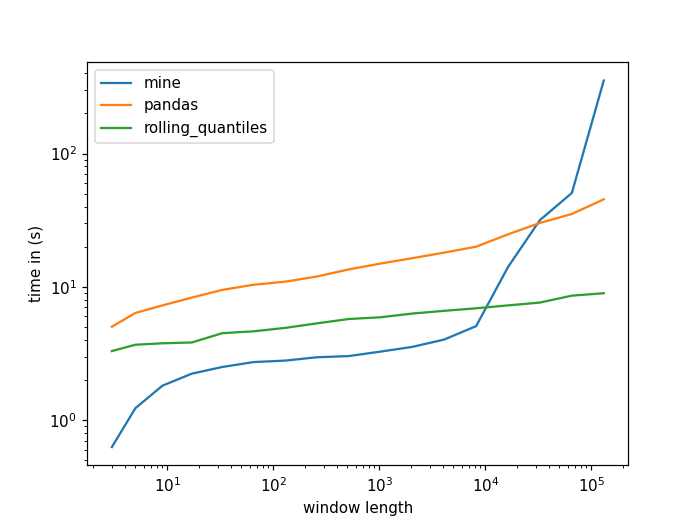

In [155]:
%matplotlib notebook
n_toShow = 3
plt.figure()
plt.plot(wins_toTest, out_times[:,:n_toShow]);
plt.xscale('log')
plt.yscale('log')
plt.xlabel('window length')
plt.ylabel('time in (s)')
plt.legend(list(rp_functions_dict.keys())[:n_toShow])

<IPython.core.display.Javascript object>


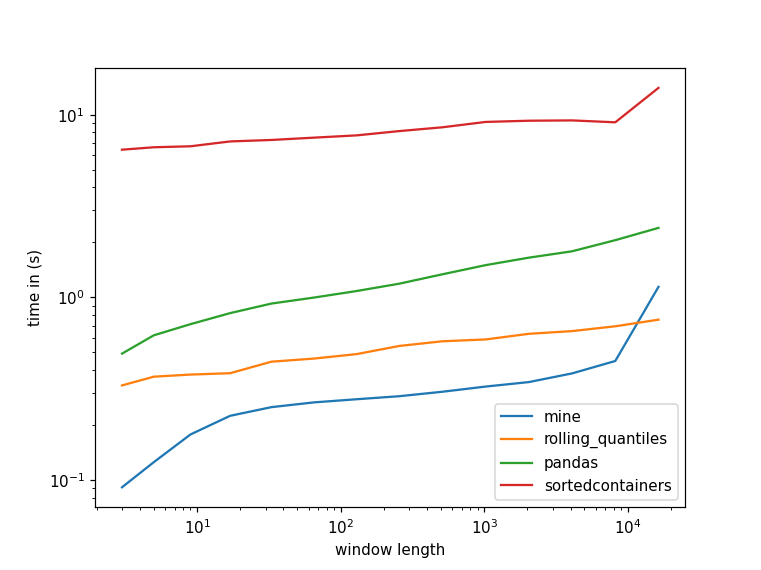

In [170]:
%matplotlib notebook
n_toShow = 4
plt.figure()
plt.plot(wins_toTest, out_times[:,:n_toShow]);
plt.xscale('log')
plt.yscale('log')
plt.xlabel('window length')
plt.ylabel('time in (s)')
plt.legend(list(rp_functions_dict.keys())[:n_toShow])